In [166]:
import os
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw

## Read data

In [2]:
DATA_PATH='data/raw/'
files=[fl for fl in os.listdir(DATA_PATH) if fl.endswith('.txt')]

txt=''
for fl in files:
    txt_=Path(DATA_PATH+fl).read_text().lower()
    
    txt_=txt_.replace('\n', '').replace('.', ' ').replace(',', ' ').replace('!', ' ').\
    replace('?', ' ').replace(':', ' ').replace(';', ' ').replace('™', ' ').replace('¶', ' ').\
    replace('(', ' ').replace(')', ' ').replace(']', ' ').replace('[', ' ').replace('„', ' ').\
    replace('“', ' ').replace('•', ' ').replace('¼', ' ').replace('¤', ' ')
    txt=f'{txt} {txt_}'

In [3]:
txt[:10]

' see oli l'

## Count char freq

In [4]:
cnt=Counter(txt.split())
len(cnt)

3572

In [5]:
df_cnt=pd.DataFrame(cnt.most_common(len(cnt)))
df_cnt.columns=['token', 'count']
df_cnt['prob']=np.divide(df_cnt['count'], df_cnt['count'].sum())
df_cnt['count_log']=np.log(df_cnt['count'])
df_cnt['prob_log']=np.log(df_cnt['prob'])
df_cnt.head()

,token,count,prob,count_log,prob_log
0,ã,452,0.037573,6.113682,-3.281477
1,ja,310,0.025769,5.736572,-3.658587
2,ta,192,0.015960,5.257495,-4.137663
3,kã,185,0.015378,5.220356,-4.174803
4,â€œ,156,0.012968,5.049856,-4.345303


<AxesSubplot:>

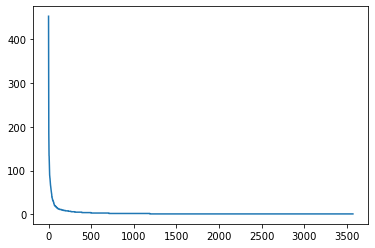

In [6]:
df_cnt['count'].plot()

<AxesSubplot:>

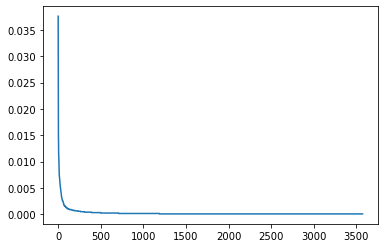

In [7]:
df_cnt['prob'].plot()

<AxesSubplot:>

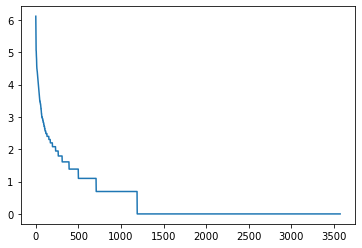

In [8]:
df_cnt['count_log'].plot()

<AxesSubplot:>

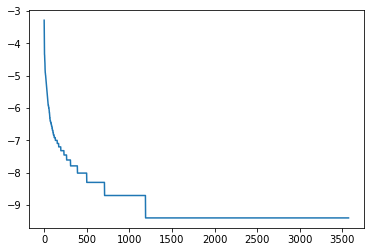

In [9]:
df_cnt['prob_log'].plot()

<AxesSubplot:xlabel='count_log', ylabel='prob_log'>

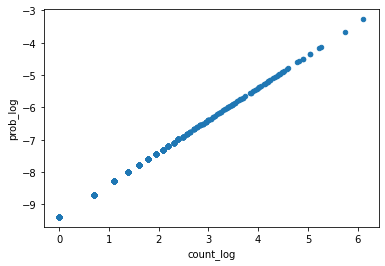

In [10]:
df_cnt.plot.scatter('count_log','prob_log')

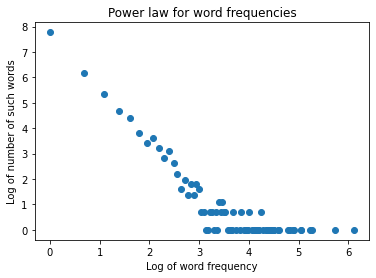

In [11]:
counter_of_words = Counter(txt.split())
counter_of_counts = Counter(counter_of_words.values())
word_counts = np.array(list(counter_of_counts.keys()))
freq_of_word_counts = np.array(list(counter_of_counts.values()))
plt.scatter(np.log(word_counts), np.log(freq_of_word_counts))
plt.xlabel('Log of word frequency')
plt.ylabel('Log of number of such words')
plt.title('Power law for word frequencies')
plt.show();

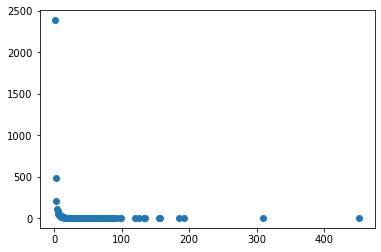

In [12]:
plt.scatter(word_counts, freq_of_word_counts)

## Estimate slope

In [13]:
def neg_zipf_likelihood(s):
    n = sum(freq_of_word_counts)
    # for each word count, find the probability that a random word has such word count
    probas = word_counts ** (-s) / np.sum(np.arange(1, n+1) **(-s))
    log_likelihood = sum(np.log(probas) * word_counts)
    return -log_likelihood

from scipy.optimize import minimize_scalar
s_best = minimize_scalar(neg_zipf_likelihood, [0.1, 3.0] )
print(s_best.x)

0.8792971547915152


## Exponential vs power law

In [14]:
x=np.arange(1, 1000)[::-1]
const=3
y_p=0.000003*x**const
y_e=1.01**x

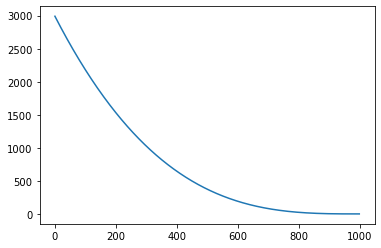

In [15]:
plt.plot(y_p)

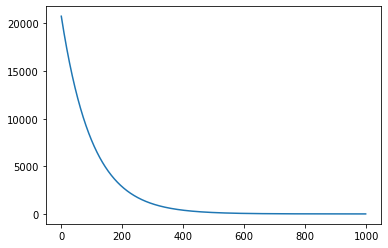

In [16]:
plt.plot(y_e)

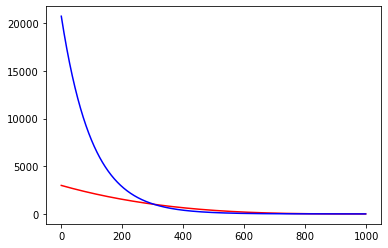

In [17]:
plt.plot(y_p, color='red')
plt.plot(y_e, color='blue')

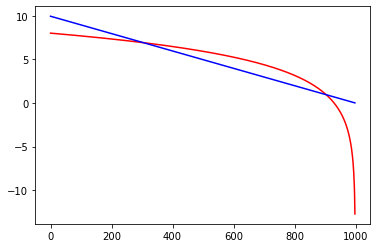

In [18]:
plt.plot(np.log(y_p), color='red')
plt.plot(np.log(y_e), color='blue')

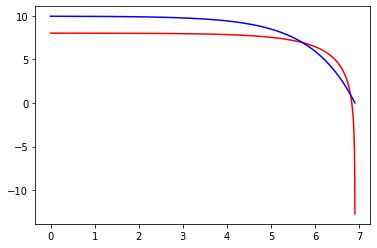

In [19]:
plt.plot(np.log(x)[::-1], np.log(y_p), color='red')
plt.plot(np.log(x)[::-1], np.log(y_e), color='blue')

## Example: https://notebook.community/puolival/power-law/powerlaw

In [20]:
def random(size=1, xmin=1, alpha=1.5):
    """Draw random numbers from a power-law distribution using the inverse
    random sampling method.

    Input arguments:
    size  - Sample size
    xmin  - Minimum value for which the power-law holds
    alpha - Scaling exponent of the power-law distribution
    """
    rvs = np.random.random(size=size)
    return float(xmin) * (1.-rvs) ** (-1. / (float(alpha)-1.))

In [21]:
-1. / (float(2.5)-1.)

-0.6666666666666666

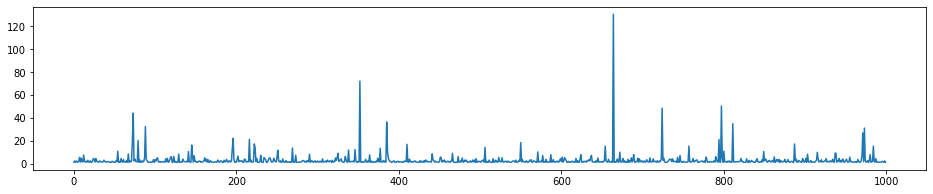

In [22]:
rvs = random(size=1000, xmin=1, alpha=2.5)
plt.figure(figsize=(16, 3)); 
plt.plot(rvs); 
plt.show()

In [23]:
def plot_ccdf(rvs):
    """Plot complementary cumulative distribution function (CCDF) of
    a possibly power-law distributed sample.

    Input arguments:
    rvs   - Analyzed random sample
    """
    # Calculate complementary CDF
    n = np.size(rvs)
    xcdf, ycdf = np.sort(rvs), np.arange(n, 0, -1) / float(n)

    # Visualize the CDF
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(111)
    ax1.loglog(xcdf, ycdf, 'o', fillstyle='none')

def mle_alpha(rvs, xmin):
    """Maximum likelihood (ML) estimate of the scaling parameter
    alpha."""
    # Select observation larger than or equal to xmin
    rvs = rvs[rvs>=xmin]
    n = np.size(rvs)

    return 1. + n * (1. / np.sum(np.log(rvs / float(xmin))))

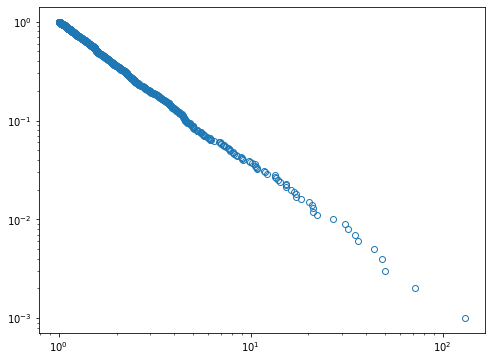

In [24]:
plot_ccdf(rvs)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_22564\3915412209.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.sort(rvs)), np.log((np.array(list(range(len(rvs))))/len(rvs))[::-1]), 'bo')


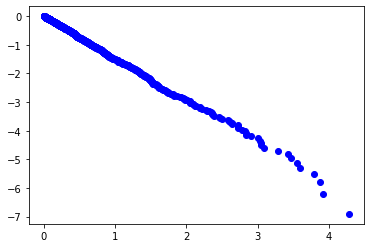

In [25]:
plt.plot(np.log(np.sort(rvs)), np.log((np.array(list(range(len(rvs))))/len(rvs))[::-1]), 'bo')

In [26]:
#scaling parameter
mle_alpha(rvs, xmin=1)

2.4709091227825746

## How mean changes when number of samples change

In [87]:
np.random.seed(134)

def gen_data(func, xmin=5.0, parameters=[2.5], num_samples=1000000):
    dist=func(xmin=xmin, parameters=parameters)
    data = dist.generate_random(1000000)
    return data

In [88]:
exp_data=gen_data(powerlaw.Exponential, xmin=5.0, parameters=[0.4])
power_data=gen_data(powerlaw.Power_Law, xmin=5.0, parameters=[2.5])

In [89]:
# power_dist = powerlaw.Power_Law(xmin=5.0, parameters=[2.5])
# exp_dist = powerlaw.Exponential(xmin=5.0, parameters=[0.4])
# theoretical_distribution = powerlaw.Power_Law(xmin=5.0, parameters=[2.5])

In [90]:
# exp_data = exp_dist.generate_random(1000000)
# power_data = power_dist.generate_random(1000000)
power_data

array([16.34534155,  6.55873127, 10.10879302, ...,  6.2620059 ,
        8.64041142, 65.70130088])

In [91]:
exp_data

array([ 9.17036534,  6.48445058,  7.47044485, ...,  6.82056206,
       16.82753418,  5.40356592])

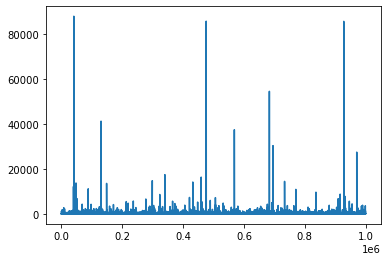

In [92]:
plt.plot(power_data)

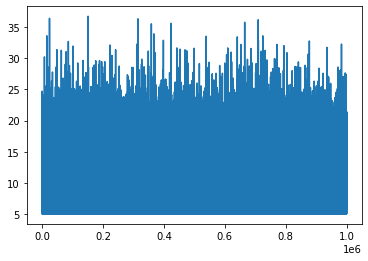

In [93]:
plt.plot(exp_data)

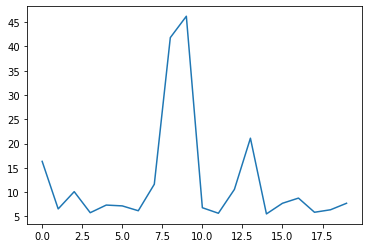

In [94]:
#plot only first samples
plt.plot(power_data[:20])

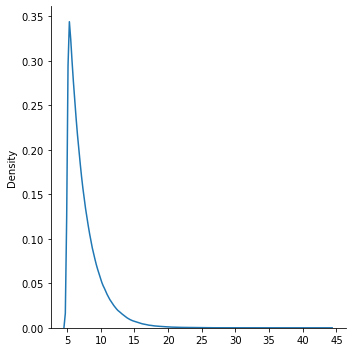

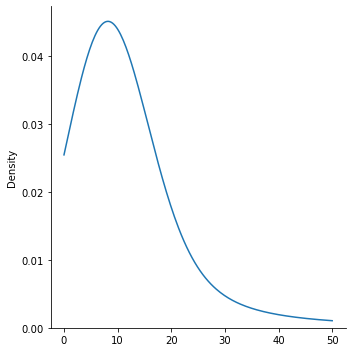

In [177]:
sns.displot(exp_data, kind="kde")
sns.displot(power_data, kind="kde", clip=(0.0, 50.0))

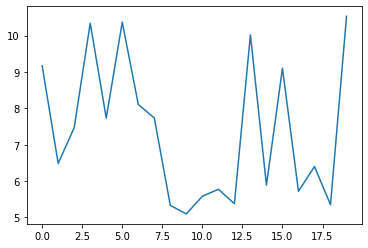

In [95]:
plt.plot(exp_data[:20])

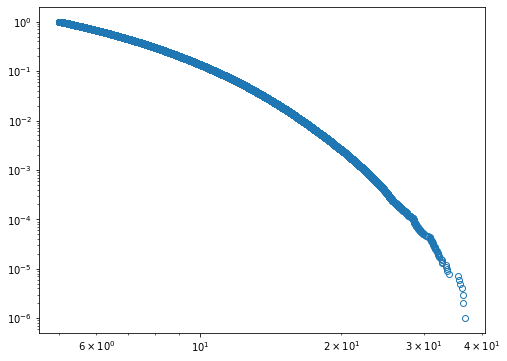

In [96]:
plot_ccdf(exp_data)

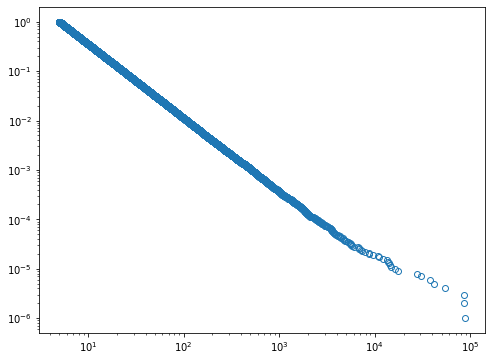

In [97]:
plot_ccdf(power_data)

In [98]:
def sample_dist_stats(power_data, exp_data, sample_sizes):
    data=[]
    for size in sample_sizes:
        power_samp=np.random.choice(power_data, size=size, replace=False)
        exp_samp=np.random.choice(exp_data, size=size, replace=False)
        data.append({'sample_size':size,
                     'power_max': np.max(power_samp),
                     'power_mean':np.mean(power_samp),
                     'power_median': np.median(power_samp),
                     'power_std': np.std(power_samp),
                     'exp_max':np.max(exp_samp),
                     'exp_mean':np.mean(exp_samp),
                     'exp_median':np.median(exp_samp),
                     'exp_std':np.std(exp_samp)})

    df_power_exp=pd.DataFrame(data)
    df_power_exp=df_power_exp.set_index(df_power_exp['sample_size'])
    return df_power_exp

In [105]:
exp_data=gen_data(powerlaw.Exponential, xmin=5.0, parameters=[0.4])
power_data=gen_data(powerlaw.Power_Law, xmin=5.0, parameters=[2.5])

df_power_exp=sample_dist_stats(power_data, exp_data, sample_sizes=[10**i for i in range(1, 7)])

In [106]:
df_power_exp

,sample_size,power_max,power_mean,power_median,power_std,exp_max,exp_mean,exp_median,exp_std
sample_size,,,,,,,,,
10,10,108.233250,17.802600,5.939313,30.394933,10.015733,6.682858,6.112111,1.624540
100,100,184.268698,12.483455,7.129676,19.637432,17.530743,7.459894,6.802051,2.244926
1000,1000,1258.960516,14.805994,7.739738,48.079856,26.394211,7.366334,6.654821,2.547023
10000,10000,3220.673355,14.659570,7.949812,45.554962,33.260342,7.485794,6.740052,2.523732
100000,100000,15728.456314,14.823459,7.930379,75.317209,38.883576,7.496430,6.731437,2.477401
1000000,1000000,61072.441765,14.935898,7.921765,111.596760,43.895167,7.498588,6.732429,2.496847


<AxesSubplot:xlabel='sample_size'>

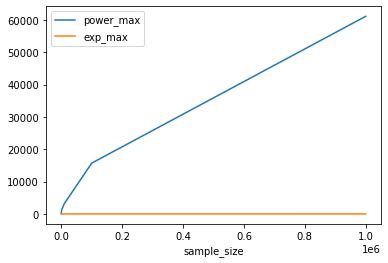

In [107]:
#maximum value we have seen is hugeliy bigger under powerlaw distribution
df_power_exp[['power_max', 'exp_max']].plot()

<AxesSubplot:xlabel='sample_size'>

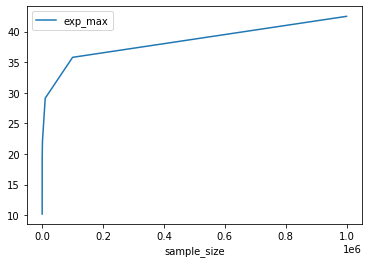

In [86]:
#in a different scale exponential function maximums have also big growth, but they are a lot smaller
df_power_exp[['exp_max']].plot()

## Different params for powerlaw function

In [170]:
exp_data2=gen_data(powerlaw.Exponential, xmin=5.0, parameters=[0.1], num_samples=1e8)
power_data2=gen_data(powerlaw.Power_Law, xmin=5.0, parameters=[1.9999], num_samples=1e8)

df_power_exp2=sample_dist_stats(power_data2, exp_data2, sample_sizes=[10**i for i in range(1, 7)])

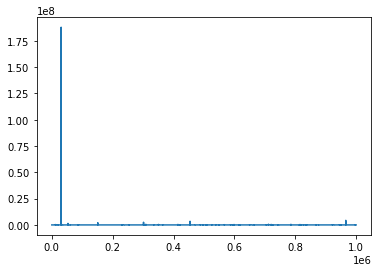

In [171]:
plt.plot(power_data2)

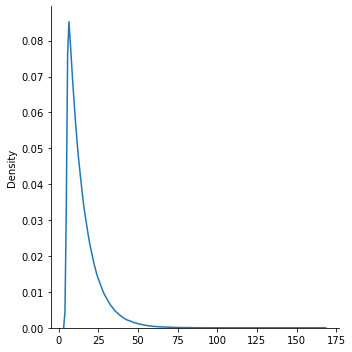

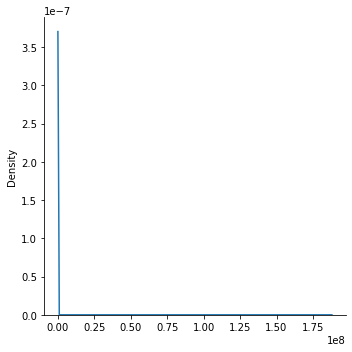

In [172]:
sns.displot(exp_data2, kind="kde")
sns.displot(power_data2, kind="kde")

In [169]:
exp_data2

array([ 6.14496386, 13.11093007,  7.67054122, ..., 22.5486973 ,
       20.09710996,  5.06389223])

In [165]:
df_power_exp2

,sample_size,power_max,power_mean,power_median,power_std,exp_max,exp_mean,exp_median,exp_std
sample_size,,,,,,,,,
10,10,1.317085e+02,22.395427,10.049671,36.755706,16.133670,10.502173,10.502112,3.018044
100,100,1.262575e+03,30.973110,9.283435,127.150133,50.096275,14.979950,12.584897,9.138264
1000,1000,3.519827e+03,33.606521,9.832293,152.219003,70.404855,14.776415,11.912219,9.967932
10000,10000,3.935604e+04,47.242672,10.059769,583.119087,88.511833,15.076067,12.170772,9.940550
100000,100000,7.509780e+05,61.086540,10.005250,2654.811476,137.004030,15.019273,11.913620,10.072334
1000000,1000000,1.051396e+07,81.324381,9.986587,12589.440746,137.004030,15.015310,11.938010,10.027200


## Extreme value

In [40]:
N=1000
maxes=[]
for i in range(N):
    power_data_ = power_dist.generate_random(1000000)
    maxes.append(power_data_.max())

(array([487., 260.,  98.,  54.,  23.,  15.,  11.,  11.,   6.,   4.,   3.,
          2.,   5.,   4.,   0.,   2.,   1.,   2.,   1.,   2.,   1.,   1.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  13425.25149638,   61207.49539048,  108989.73928459,
         156771.98317869,  204554.2270728 ,  252336.4709669 ,
         300118.714861  ,  347900.95875511,  395683.20264921,
         443465.44654332,  491247.69043742,  539029.93433152,
         586812.17822563,  634594.42211973,  682376.66601384,
        

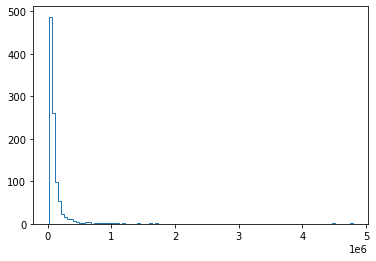

In [41]:
plt.hist(maxes, bins=100, histtype='step')

(array([ 487.,  747.,  845.,  899.,  922.,  937.,  948.,  959.,  965.,
         969.,  972.,  974.,  979.,  983.,  983.,  985.,  986.,  988.,
         989.,  991.,  992.,  993.,  994.,  994.,  995.,  995.,  995.,
         995.,  995.,  996.,  996.,  996.,  996.,  997.,  997.,  998.,
         998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,
         998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,
         998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,
         998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,
         998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,
         998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,  998.,
         998.,  998.,  998.,  999.,  999.,  999.,  999.,  999.,  999.,
        1000.]),
 array([  13425.25149638,   61207.49539048,  108989.73928459,
         156771.98317869,  204554.2270728 ,  252336.4709669 ,
         300118.714861  ,  347900.95875511,  395683.20264921,
         443465.

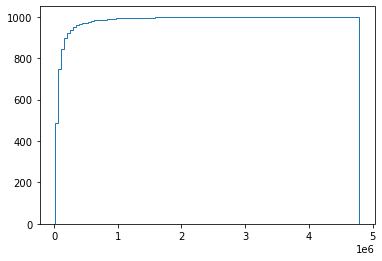

In [42]:
plt.hist(maxes, bins=100, cumulative=True, histtype='step')